In [1]:
import numpy as np
import joypy
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance

from skimage import io
from skimage.color import rgb2gray
from scipy import ndimage
from skimage import filters
from skimage.morphology import disk, ball

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

%load_ext cython

https://en.wikipedia.org/wiki/Convex_hull

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0230342

In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [3]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])

def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [4]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

# у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

image1=(bin_grad1>0).astype('uint8')*255
image2=(bin_grad2>0).astype('uint8')*255
image3=(bin_grad3>0).astype('uint8')*255

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [5]:
#io.imsave('bin_grad.png',image)

## Маркировка углов

http://espressocode.top/python-corner-detection-with-shi-tomasi-corner-detection-method-using-opencv/

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [27]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.001, 1)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    return image,corners.astype('int64')

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [28]:
grain1_marked,grain1_corners=mark_corners(image1)
grain2_marked,grain2_corners=mark_corners(image2)
grain3_marked,grain3_corners=mark_corners(image3)

grain1_classes,class1_num=mark_classes(image1)
grain2_classes,class2_num=mark_classes(image2)
grain3_classes,class3_num=mark_classes(image3)

number of corners:  1633
number of corners:  13247
number of corners:  30747
number of classes: 196
number of classes: 342
number of classes: 1244


## Дадим каждой вершине привязку к пустоте

In [8]:
def join_corners2classes(classes,classes_num,corners,max_corners_per_class):

    shape=(classes_num+1,max_corners_per_class)
    nodes=np.zeros(shape,dtype='int64')
    r=2
    num1=0
    num0=0
    for i,corner in enumerate(corners):
        x=corner[0][0]
        y=corner[0][1]
        cls=classes[x,y]
        real_cls=0
        flag=True
        x_lin=range(x-r,x+r)
        y_lin=range(y-r,y+r)
        while flag:
            for xi in range(x-r,x+r):
                for yi in y_lin:
                    if classes[xi,yi]!=0 and classes[xi,yi]!=1 and classes[xi,yi]!=2:
                        real_cls=classes[xi,yi]
                        flag=False
                    elif yi==y_lin[-1] and xi==x_lin[-1]:
                        flag=False
                        
        
        index=np.where(nodes[real_cls]==0)[0][0]
        nodes[real_cls,index]=i
        nodes[real_cls,-1]+=1 # вносит погрешность


    return nodes

In [31]:
nodes1=join_corners2classes(grain1_classes,
                             class1_num,
                             grain1_corners,
                             100)

nodes2=join_corners2classes(grain2_classes,
                             class2_num,
                             grain2_corners,
                             500)

nodes3=join_corners2classes(grain3_classes,
                             class3_num,
                             grain3_corners,
                             600)


## Подсчитаем количество углов у пустот

In [ ]:
def show_corners_classes(nodes,classes,N=2000): 
    node_corner_numbers=np.zeros((classes.shape[0],1))
    for i,node in enumerate(nodes):
        for corner in node:
            if corner:
                node_corner_numbers[i]+=1

    std=node_corner_numbers.std(axis=0)[0]
    mean=node_corner_numbers.mean(axis=0)[0]

    print('std: ',round(std,3))
    print('mean: ',round(mean,3))
    print('number of classes: ',classes.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_ylabel('Количество углов у пустоты',size=20)
    ax.set_xlabel('Порядковый номер пустоты',size=20)
    plt.plot(node_corner_numbers[:N])

In [ ]:
N=1300
show_corners_classes(nodes3,grain3_classes,N)

## Подсчитаем количество пустот, в которые входит угол

In [ ]:
def show_classes_corners(nodes,corners,N=2000,N1=5):   
    corner_distr=np.zeros((corners.shape[0]))
    
    for i in range(corners.shape[0]):
        for node in nodes:
            node_len=node[-1]
            if i in node[:node_len]:
                corner_distr[i]+=1
                
    std=corner_distr.std(axis=0)
    mean=corner_distr.mean(axis=0)

    print('std: ',std)
    print('mean: ',mean)
    fig, ax = plt.subplots(figsize=(N1,N1))
    ax.set_ylabel('Количество вхождений в пустоту',size=20)
    ax.set_xlabel('Порядковый номер угла',size=20)
    plt.plot(corner_distr[:N])
    plt.show()
    return corner_distr

In [ ]:
k=50
#corner_distr1=show_classes_corners(nodes1,grain1_corners,k)
corner_distr2=show_classes_corners(nodes2,grain2_corners,k)
#corner_distr3=show_classes_corners(nodes3,grain3_corners,k)

## Соединим углы пустоты по периметру

https://ru.wikipedia.org/wiki/Алгоритм_Брезенхэма
https://ru.wikibooks.org/wiki/Реализации_алгоритмов/Алгоритм_Брезенхэма

In [10]:
def get_line(point1,point2):
    line=[]
    
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]
    
    dx = x2 - x1
    dy = y2 - y1

    sign_x = 1 if dx>0 else -1 if dx<0 else 0
    sign_y = 1 if dy>0 else -1 if dy<0 else 0

    if dx < 0: dx = -dx
    if dy < 0: dy = -dy

    if dx > dy:
        pdx, pdy = sign_x, 0
        es, el = dy, dx
    else:
        pdx, pdy = 0, sign_y
        es, el = dx, dy

    x, y = x1, y1
    error, t = el/2, 0        

    line.append((x, y))

    while t < el:
        error -= es
        if error < 0:
            error += el
            x += sign_x
            y += sign_y
        else:
            x += pdx
            y += pdy
        t += 1
        line.append((x, y))
    return np.array(line).astype('int')

In [16]:
def draw_rect(image,point1,point2,r):
    
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]
    
    l1,l2=(x2-x1),(y2-y1)
    
    l_len=(l1**2+l2**2)**0.5
    l_len=int(l_len)
    
    a=(x1-r*l2/l_len),(y1+r*l1/l_len)
    b=(x1+r*l2/l_len),(y1-r*l1/l_len)
    
    side=get_line(a,b)
    
    # a -> c
    lines=np.zeros((side.shape[0],l_len*2,2),dtype='int64')

    for i,left_point in enumerate(side):
        right_point=(left_point[0]+l1),(left_point[1]+l2)
        line_points=get_line(left_point,right_point)
        for j,point in enumerate(line_points):
            lines[i,j]=point

    val=0
    num=0
    for line in lines:
        for point in line:
            if point[0]!=0:
                x=point[0]
                y=point[1]

                val+=image[x,y]
                num+=1
    return val,num

In [17]:
def mean_pixel(image,point1,point2,r):

    
    val1,num1=draw_rect(image,point1,point2,r)
    val2,num2=draw_rect(image,point2,point1,r)
    val=val1+val2
    num=num1+num2

    if num!=0 and val!=0:
        mean=(val/num)/255
        dist=distance.euclidean(point1,point2)
    else:
        mean=0
        dist=0
    return mean,dist

In [18]:
def estimate_edges(image,node,corners,position=0,radius=2):
    # вычисление расстояния и среднего значения между 
    # точкой с индексом posion и остальными точками пустоты
    v1=node[position]
    vals=np.zeros((len(node),3))
    if v1!=0:
        for i,v2 in enumerate(node):

            if v2!=0 and v1!=v2  :
                vals[i,0]=v2
                point1=corners[v1]
                point2=corners[v2]
                mean,dist=mean_pixel(image,point1[0],point2[0],radius)
                vals[i,1]=mean
                vals[i,2]=dist
                
    vals=vals[np.argsort(vals[:,2])]
    return vals
        

In [35]:
def sort_perimetr(image,nodes,eps,corners,radius):
    new_nodes=np.zeros(nodes.shape,dtype='int64')
    
    # проходим по каждой пустоте
    for i,orig_node in enumerate(nodes):
    # node - пустота
        v1_index=0
        v1=orig_node[v1_index] # фиксируем первый угол и затем будем считать относительно него
        step=1
        new_nodes[i,0]=v1
        flag=True
        orig_node_len=orig_node[-1]
        node=list(copy.copy(orig_node[:orig_node_len]))
       # norm_val=mean_dist_points(node,corners)
      #  print('i=',i, ' max=',nodes.shape[0])
      #  print('-------------')
       # print('old_node',node)
        print('new_node')
        if v1!=0 and len(node)>1:
            while flag:
        #        print('delete_node,iteration start',node)
         #       print('v1',v1)
                vals=estimate_edges(image,node,corners,position=v1_index,radius=radius)
                non_zero_indeces=np.where((vals[:,0][:orig_node_len]!=0) )[0]
                vals=vals[non_zero_indeces]
                print('new kernel point')

#                min_val=vals.min(axis=0)[1]
            #    for j,val in enumerate(vals):
            #        mean=val[1]
            #       print('point',val[0],'mean=',mean, 'dist',val[2])
            #        if abs(mean-0.5)<=eps:
                v2=vals[0][0]
            #            break
             #       elif j==vals.shape[0]-1:
             #           v2=val[0]
             #           break
                
              #  print('min_val',min_val)
 #               v2_vals_index=np.where(vals[:,1]==min_val )[0][0]
           #     v2=vals[v2_vals_index][0]
           #     print('v2',v2)

                new_nodes[i,step]=v2
                node.pop(v1_index)

                v1=v2
                v2_index=node.index(v2)

            #    print('v2_index',v2_index)
                v1_index=v2_index

                
           #     if len(node)==1:
          #           new_nodes[i,step+1]=node[0]
         #           flag=False
                    
                step+=1
                if step==orig_node_len:
                    flag=False
               
        else:
            continue
        new_nodes[i,-1]= orig_node_len
    return new_nodes

new_node
new kernel point
new kernel point
new kernel point
new_node
new_node
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new_node
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new_node
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new kernel point
new

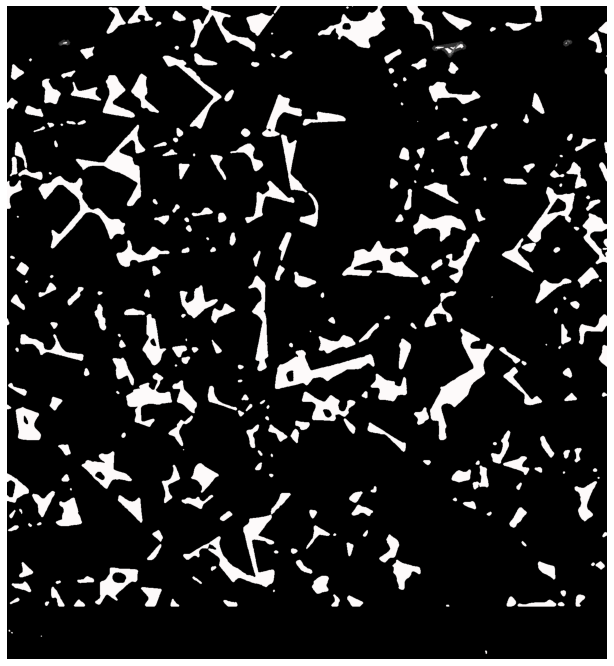

In [43]:
image=image2
radius=6
eps=0.1

img=Image.fromarray(image)
image = ImageOps.expand(img,border=radius,fill='black')
image=np.array(image)


new_nodes=sort_perimetr(image,nodes2[20:25],eps,grain2_corners,radius=radius)

img=draw_edges(image2,new_nodes[2:50],grain2_corners)
img_show(img,cmap='gray',N=12)
name='vals.png'
io.imsave(name,img)

In [23]:
def draw_edges(image,nodes,corners,color=(51,51,51)):
    new_image=copy.copy(image)
    
    im = Image.fromarray(np.uint8(cm.gist_earth(new_image)*255))
    draw = ImageDraw.Draw(im)
    for j,node in enumerate(nodes):
        if len(node)>1:
         #   print('i=',j)
        #    print(node)
            point1=corners[node[0]][0]
            x1,y1=point1[0],point1[1]
            x_start,y_start=point1[0],point1[1]
            r1=5
            r=3
            draw.ellipse((y1-r1,x1-r1,y1+r1,x1+r1), fill=color, width=10)
            len_node=node[-1]
       #     print(node[:len_node])
            for i,point in enumerate(node[: len_node]):
                point2=corners[point][0]
                x2,y2=point2[0],point2[1]

                draw.ellipse((y2-r,x2-r,y2+r,x2+r), fill=color, width=4)
                draw.line((y1,x1,y2,x2), fill=color, width=4)
                x1,y1=x2,y2
                
            draw.line((y_start,x_start,y1,x1), fill=(100,100,100), width=4)
        else:
            continue

    img=np.array(im)

    return  img
        

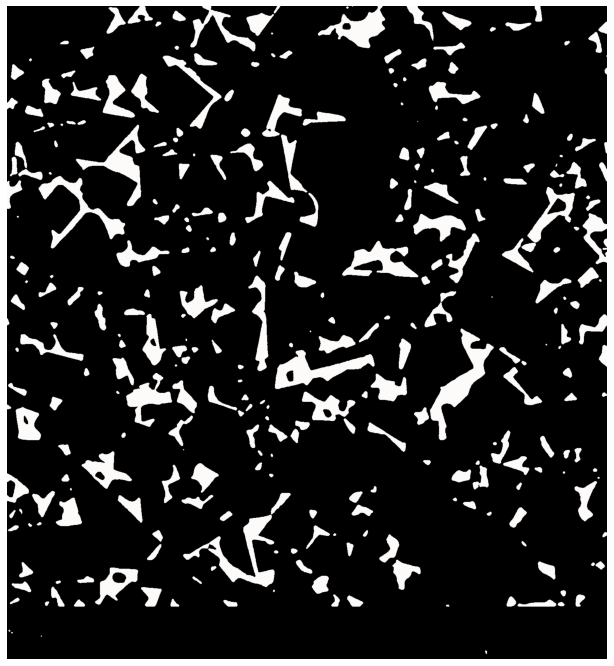

In [42]:
img=draw_edges(image2,new_nodes[20:25],grain2_corners)
img_show(img,cmap='gray',N=12)
name='vals.png'
io.imsave(name,img)